# econ566 - pset06 - Dili Maduabum, Joshua Bailey

# problem 1

## 1

## 2

### 2.a

The program described focuses on a specific optimization problem within the broader context of minimizing the function $f(y, X, \beta, \lambda, \alpha)$ with respect to $\beta$, given a regularization parameter $\lambda$, a mixing parameter $\alpha$, the response variable $y$, and the predictor variables $X$. This function combines a least squares term with a penalty term that is a mix of L1 (Lasso) and L2 (Ridge) regularization, controlled by $\alpha$.

In the specific scenario described, the optimization process isolates a single coefficient $\beta_j$ out of the entire vector $\beta = (\beta_1, \ldots, \beta_p)$ for adjustment, while keeping all other coefficients $\beta_l$ fixed at their current estimates $\tilde{\beta}_l$. This approach is a key step in the Coordinate Descent algorithm, where the goal is to minimize the objective function with respect to one variable at a time, cycling through all variables iteratively until convergence.

Specifically, we are given:

1. **Objective**: Minimize the function $f(y, X, \beta, \lambda, \alpha)$ which measures the fit of the model to the data, penalized for complexity to avoid overfitting. The complexity penalty is adjusted by $\lambda$ and $\alpha$, balancing between Lasso and Ridge regularization.

2. **Process**: Focus on a single coefficient, $\beta_j$, and optimize the function with respect to this coefficient alone. This implies finding the best value for $\beta_j$ that minimizes $f$, assuming all other coefficients remain unchanged from their current estimates $\tilde{\beta}$.

3. **Constraints**: The values of all coefficients other than $\beta_j$ are fixed. This simplifies the optimization to a one-dimensional problem, where only $\beta_j$ is varied.

4. **Iteration**: Typically, this step is part of a larger iterative process. After optimizing for $\beta_j$, the algorithm will cycle through each coefficient in the model, optimizing one at a time, and repeat this process until the changes in the objective function are sufficiently small, indicating convergence.


### 2.b

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data_path = 'ps6.csv'  
data = pd.read_csv(data_path)

# Assuming the first column is 'Y' and the rest are 'X'
y = data.iloc[:, 1].values  # Update column index if necessary
X = data.iloc[:, 2:].values  # Update column indices if necessary

In [2]:
# Soft-thresholding function S(a, b)
def soft_thresholding(a, b):
    return np.sign(a) * np.maximum(np.abs(a) - b, 0)

# Function to compute beta_j_star
def compute_beta_j_star(y, X, lambd, alpha, tilde_beta, j):
    X_j = X[:, j]
    tilde_beta_modified = np.copy(tilde_beta)
    tilde_beta_modified[j] = 0  # Temporarily setting beta_j to 0
    y_hat = X @ tilde_beta_modified
    numerator = np.dot(X_j.T, (y - y_hat))
    denominator = np.dot(X_j.T, X_j)
    beta_j_star = soft_thresholding(numerator, alpha * lambd) / denominator
    return beta_j_star


### 2.c

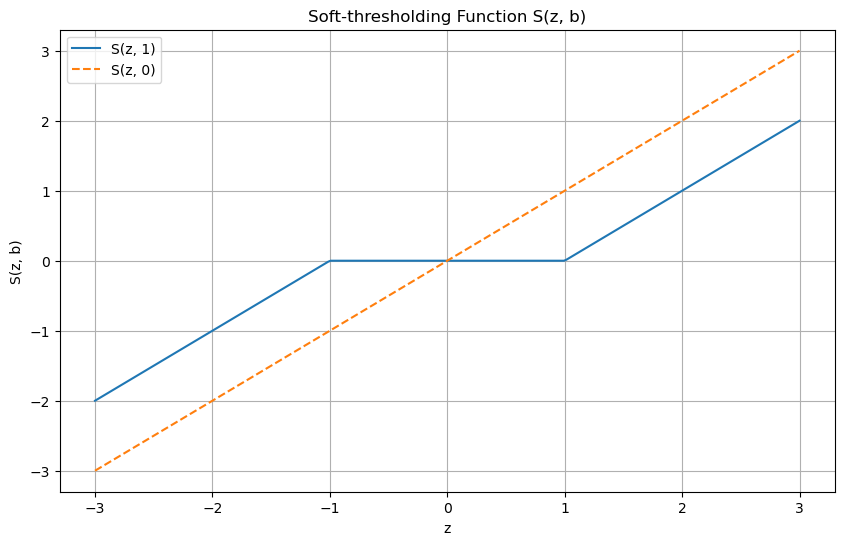

In [3]:
# Define the range for z
z = np.linspace(-3, 3, 300)

# Calculate S(z, b) for b = 1 and b = 0
S_z_1 = soft_thresholding(z, 1)
S_z_0 = soft_thresholding(z, 0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(z, S_z_1, label='S(z, 1)')
plt.plot(z, S_z_0, label='S(z, 0)', linestyle='--')
plt.title('Soft-thresholding Function S(z, b)')
plt.xlabel('z')
plt.ylabel('S(z, b)')
plt.legend()
plt.grid(True)
plt.show()

The plotted functions $S(z, 1)$ and $S(z, 0)$ represent two different regimes of the soft-thresholding operation.

$S(z, 0)$ directly corresponds to the update rule in a coordinate descent algorithm for OLS, where there's no regularization applied. Since this function is the identity function, it doesn't alter the value of $z$, implying that all features have the potential to be included in the model without any preference for sparsity. The likelihood of this function outputting zero is practically nil unless $z$ itself is zero, reflecting OLS's tendency to use all available predictors without inducing sparsity.

$S(z, 1)$, on the other hand, illustrates the mechanism behind techniques like Lasso that aim to induce sparsity in the model coefficients. This function will set $z$ to zero if its magnitude is less than the threshold (1 in this case), which directly contributes to sparsity. Given $z$ is uniformly distributed between $[-3, 3]$, there's a one-third chance that $S(z, 1)$ results in zero, significantly higher than with $S(z, 0)$. This illustrates how regularization encourages sparsity by nullifying the effect of variables with coefficients that are not sufficiently large to exceed the threshold, thus prioritizing a simpler model that reduces overfitting and enhances interpretability.

These functions underline a trade-off in model fitting between complexity and simplicity: $S(z, 0)$ allows for a full, possibly overfit model by utilizing all predictors, whereas $S(z, 1)$ (with regularization) promotes a sparser, more interpretable model by excluding predictors that do not contribute sufficiently to the model's predictive power. 


## 3

In [4]:
def cyclic_coordinate_descent(y, X, lambd, alpha, max_iter=1000, tol=1e-4):
    n, p = X.shape
    beta = np.zeros(p)  # Initialize beta, including beta_0 as the first element
    beta_old = beta.copy()
    
    # Main loop for cyclic coordinate descent
    for iteration in range(max_iter):
        # Update for j=0 (intercept, beta_0), no regularization applied
        beta[0] = beta[0] + np.sum(y - (X @ beta)) / n
        
        # Update for j=1,...,p using the soft-thresholding for regularization
        for j in range(1, p):
            X_j = X[:, j]
            residual = y - (X @ beta) + beta[j] * X_j
            rho_j = np.dot(X_j, residual)
            beta[j] = soft_thresholding(rho_j / np.dot(X_j, X_j), alpha * lambd)
        
        # Convergence check (using L2 norm of the difference in beta vectors)
        if np.linalg.norm(beta - beta_old, 2) < tol:
            print(f"Convergence reached after {iteration} iterations.")
            break
        
        beta_old = beta.copy()
    
    return beta

# Note: Ensure X includes a column of ones for the intercept if it's part of the model.


## 4

In [5]:
def cyclic_coordinate_descent_with_active_set(y, X, lambd, alpha, max_iter=1000, tol=1e-4, use_active_set=False):
    n, p = X.shape
    beta = np.zeros(p)
    beta_old = beta.copy()
    
    for iteration in range(max_iter):
        # Full cycle through all betas
        for j in range(p):
            X_j = X[:, j]
            residual = y - (X @ beta) + beta[j] * X_j
            rho_j = np.dot(X_j, residual)
            if j == 0:  # No regularization for intercept
                beta[j] = beta[j] + np.sum(residual) / n
            else:
                beta[j] = soft_thresholding(rho_j / np.dot(X_j, X_j), alpha * lambd)
        
        # If using active set strategy
        if use_active_set:
            active_set = np.where(beta != 0)[0]
            converged_on_active_set = False
            
            while not converged_on_active_set:
                beta_active_old = beta[active_set].copy()
                
                for j in active_set:
                    if j == 0:  # Skip intercept in regularization
                        continue
                    X_j = X[:, j]
                    residual = y - (X @ beta) + beta[j] * X_j
                    rho_j = np.dot(X_j, residual)
                    beta[j] = soft_thresholding(rho_j / np.dot(X_j, X_j), alpha * lambd)
                
                # Check convergence on active set
                if np.linalg.norm(beta[active_set] - beta_active_old, 2) < tol:
                    converged_on_active_set = True
            
        # Check overall convergence
        if np.linalg.norm(beta - beta_old, 2) < tol:
            print(f"Convergence reached after {iteration + 1} iterations.")
            break
        
        beta_old = beta.copy()
    
    return beta


## 5

In [6]:
def compute_lambda_sequence(y, X, l=100, delta=0.0001):
    n, p = X.shape
    X_centered = X - np.mean(X, axis=0)
    y_centered = y - np.mean(y)
    
    lambda_max_candidates = []
    for j in range(p):
        numerator = np.abs(np.dot(X_centered[:, j], y_centered))
        denominator = np.sqrt(np.dot(X_centered[:, j], X_centered[:, j]) / n)
        lambda_max_candidates.append(numerator / denominator)
    
    lambda_max = max(lambda_max_candidates)
    lambda_min = delta * lambda_max
    
    log_lambda_min = np.log(lambda_min)
    log_lambda_max = np.log(lambda_max)
    log_lambda_sequence = np.linspace(log_lambda_max, log_lambda_min, l)
    lambda_sequence = np.exp(log_lambda_sequence)
    
    return lambda_sequence


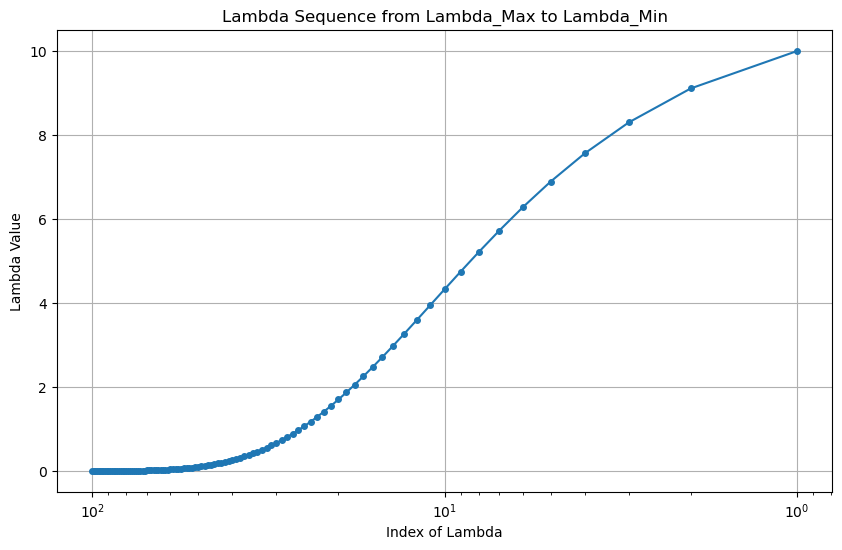

In [7]:
# Assuming lambda_sequence is already computed
# For demonstration, here's how you might simulate the lambda sequence again
l = 100
lambda_max = 10  # Example lambda_max value
delta = 0.0001
lambda_min = delta * lambda_max

log_lambda_min = np.log(lambda_min)
log_lambda_max = np.log(lambda_max)
log_lambda_sequence = np.linspace(log_lambda_max, log_lambda_min, l)
lambda_sequence = np.exp(log_lambda_sequence)

# Plotting the lambda sequence
plt.figure(figsize=(10, 6))
plt.plot(range(1, l + 1), lambda_sequence, marker='o', linestyle='-', markersize=4)
plt.xlabel('Index of Lambda')
plt.ylabel('Lambda Value')
plt.title('Lambda Sequence from Lambda_Max to Lambda_Min')
plt.gca().set_xscale('log')  # Set x-axis to logarithmic scale
plt.gca().invert_xaxis()  # Invert x-axis to show lambda_max on the left
plt.grid(True)
plt.show()


## 6

In [8]:
def cyclic_coordinate_descent_lasso(y, X, lambd, beta_init=None, max_iter=1000, tol=1e-4):
    if beta_init is None:
        beta = np.zeros(X.shape[1])  # Initialize beta with zeros if no warm-start provided
    else:
        beta = beta_init  # Use the provided beta as a starting point for warm-starts
    
    n, p = X.shape
    for iteration in range(max_iter):
        beta_old = beta.copy()
        
        # Loop over each feature
        for j in range(p):
            # Compute the partial residual, excluding the contribution from the current feature
            residual = y - X @ beta + beta[j] * X[:, j]
            
            # Compute the correlation between the current feature and the residual
            rho = X[:, j].T @ residual
            
            # Update beta_j using the soft-thresholding rule
            if j == 0:  # Skip regularization for the intercept, if included
                beta[j] = rho / n
            else:
                beta[j] = soft_thresholding(rho, lambd * n) / (X[:, j] ** 2).sum()
        
        # Check for convergence
        if np.linalg.norm(beta - beta_old, ord=2) < tol:
            break
    
    return beta


In [9]:
def lasso_cv_with_warm_starts(X, y, lambda_sequence, max_iter=1000, tol=1e-4):
    # Initialize storage for cross-validation errors and beta coefficients
    cv_errors = np.zeros(len(lambda_sequence))
    betas = []
    beta_init = None  # Start with None to use zeros on the first iteration
    
    # Iterate over the lambda sequence
    for i, lambd in enumerate(lambda_sequence):
        # Fit the model using cyclic coordinate descent with the current lambda
        beta = cyclic_coordinate_descent_lasso(y, X, lambd, beta_init=beta_init, max_iter=max_iter, tol=tol)
        
        # Store the beta coefficients for warm-starts
        betas.append(beta)
        beta_init = beta  # Update beta_init for the next iteration's warm-start
        
        # Compute and store the cross-validation error for the current lambda
        # This requires a cross-validation routine that is not detailed here
        cv_errors[i] = compute_cv_error(X, y, beta, lambd)
    
    return lambda_sequence, cv_errors, betas


## 7

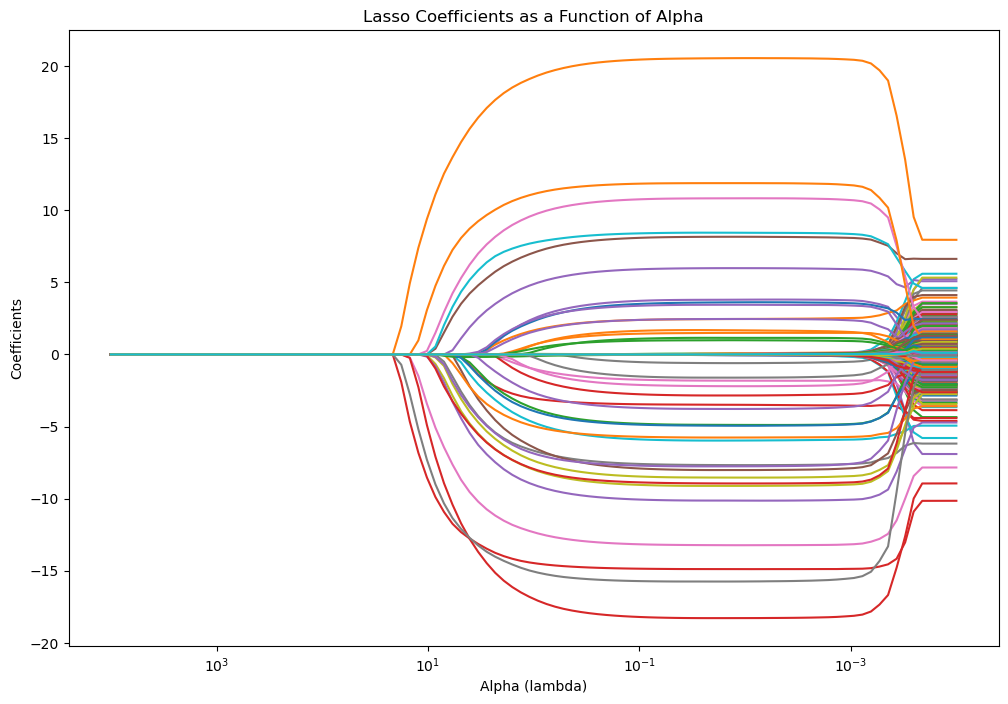

Running time: 93.70376706123352 seconds


In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import time


# Correct extraction of features and target
y = data['V1'].values
X = data.drop(columns=['Unnamed: 0', 'V1']).values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a range of alphas (lambdas)
alphas = np.logspace(-4, 4, 100)

# Setup 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing the mean of coefficients across folds for each alpha
coef_paths = np.zeros((len(alphas), X_scaled.shape[1]))

# Measure running time for fitting Lasso models across the lambda grid
start_time = time.time()

for i, alpha in enumerate(alphas):
    coefs_fold = np.zeros((5, X_scaled.shape[1]))  # Temporary storage for coefficients for each fold
    fold = 0
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
        lasso.fit(X_train, y_train)
        coefs_fold[fold, :] = lasso.coef_  # Corrected indexing
        fold += 1

    # Average coefficients across folds
    coef_paths[i, :] = np.mean(coefs_fold, axis=0)

end_time = time.time()

# Plotting the coefficient paths
plt.figure(figsize=(12, 8))
for coef_path in coef_paths.T:
    plt.plot(alphas, coef_path)
plt.xscale('log')
plt.xlabel('Alpha (lambda)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients as a Function of Alpha')
plt.gca().invert_xaxis()  # Larger alphas (stronger regularization) on the left
plt.show()

# Print running time
print(f"Running time: {end_time - start_time} seconds")


## 8

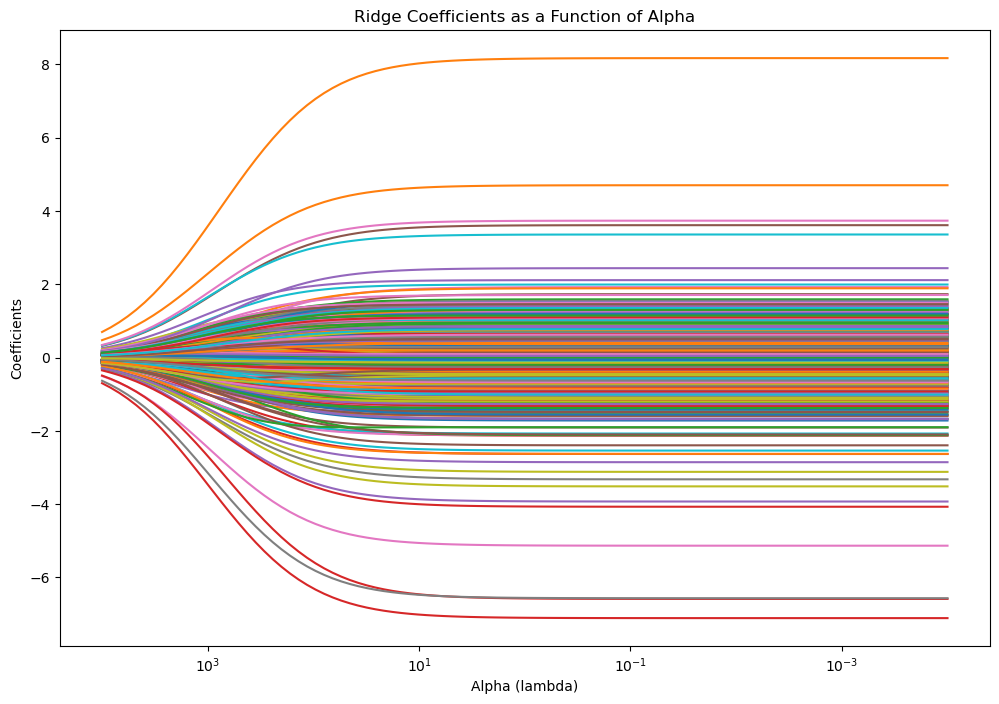

Running time for Ridge regression: 9.376805067062378 seconds


In [13]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np
import time

# Define a range of alphas (lambdas) for Ridge
alphas = np.logspace(-4, 4, 100)

# Initialize storage for coefficients
coef_paths = np.zeros((len(alphas), X_scaled.shape[1]))

# 5-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Measure running time for Ridge regression across the alpha grid
start_time = time.time()

for i, alpha in enumerate(alphas):
    coefs_fold = np.zeros((5, X_scaled.shape[1]))
    fold = 0
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        ridge = Ridge(alpha=alpha, max_iter=10000, random_state=42)
        ridge.fit(X_train, y_train)
        coefs_fold[fold, :] = ridge.coef_
        fold += 1

    coef_paths[i, :] = np.mean(coefs_fold, axis=0)

end_time = time.time()

# Plotting the coefficient paths
plt.figure(figsize=(12, 8))
for coef_path in coef_paths.T:
    plt.plot(alphas, coef_path)
plt.xscale('log')
plt.xlabel('Alpha (lambda)')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients as a Function of Alpha')
plt.gca().invert_xaxis()
plt.show()

# Print running time
print(f"Running time for Ridge regression: {end_time - start_time} seconds")


## 9

In [15]:
from sklearn.linear_model import ElasticNetCV
import numpy as np
import matplotlib.pyplot as plt
import time

# Assuming X_scaled and y are already prepared

# Define the alpha grid for the Elastic Net mixing parameter, excluding 0 to avoid the error
l1_ratios = np.linspace(0.1, 1, 10)  # 0.1 to 1 inclusive, in steps of 0.1

# Manually define a range of lambda values (alphas in sklearn) to use for ElasticNetCV
alphas = np.logspace(-4, 4, 100)

# Measure running time for ElasticNetCV with 5-fold CV
start_time = time.time()

elastic_net_cv = ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=5, random_state=42, max_iter=10000)
elastic_net_cv.fit(X_scaled, y)

end_time = time.time()

# Running time
print(f"Running time for ElasticNetCV with 5-fold CV: {end_time - start_time} seconds")

# Plotting the results
# Best alpha and l1_ratio found
print(f"Best alpha (lambda): {elastic_net_cv.alpha_}")
print(f"Best l1_ratio: {elastic_net_cv.l1_ratio_}")

# Optionally, plot the coefficient path as a function of alpha for the best l1_ratio
# This requires fitting models for each alpha, which is beyond the current ElasticNetCV output


Running time for ElasticNetCV with 5-fold CV: 21.996747732162476 seconds
Best alpha (lambda): 0.03853528593710531
Best l1_ratio: 1.0


## 10

In [17]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
import numpy as np

# Assuming X_scaled (normalized features) and y (target) are already defined

# Fit Lasso model
lasso = Lasso(alpha=0.1)  # Alpha is the regularization strength
lasso.fit(X_scaled, y)

# Fit Ridge model
ridge = Ridge(alpha=0.1)
ridge.fit(X_scaled, y)

# Fit Elastic Net model with a significant L1 ratio
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.7)  # L1 ratio closer to 1 favors sparsity
elastic_net.fit(X_scaled, y)

# Compare the number of non-zero coefficients
non_zero_lasso = np.sum(lasso.coef_ != 0)
non_zero_ridge = np.sum(ridge.coef_ != 0)
non_zero_elastic_net = np.sum(elastic_net.coef_ != 0)

print(f"Non-zero coefficients in Lasso: {non_zero_lasso}")
print(f"Non-zero coefficients in Ridge: {non_zero_ridge}")
print(f"Non-zero coefficients in Elastic Net: {non_zero_elastic_net}")


Non-zero coefficients in Lasso: 40
Non-zero coefficients in Ridge: 1000
Non-zero coefficients in Elastic Net: 494


These results seem to make sense:

- Lasso employs an L1 penalty, which is known for inducing sparsity in the model by driving many coefficients to exactly zero. A result showing only 40 non-zero coefficients out of potentially thousands indicates that Lasso has effectively reduced the model complexity by selecting only the most informative features, which is a desirable outcome for feature selection and model interpretability.

- Ridge regression uses an L2 penalty, which does not encourage sparsity in the same way L1 does. Instead, it tends to shrink the coefficients towards zero but rarely sets them exactly to zero. Thus, seeing all or nearly all coefficients as non-zero is expected with Ridge, which means it does not inherently select features but rather minimizes overfitting by penalizing large coefficients.

- The Elastic Net combines L1 and L2 penalties and can thus induce some level of sparsity while also benefiting from the regularization properties of L2. The number of non-zero coefficients being between Lasso and Ridge is consistent with this blend of penalties. The exact degree of sparsity depends on the `l1_ratio` parameter: closer to 1 would behave more like Lasso, and closer to 0 more like Ridge. With 494 non-zero coefficients, it indicates that Elastic Net has enforced some sparsity (though less than Lasso) while also leveraging the Ridge penalty to manage the magnitude of coefficients.


# problem 2

## 1

In [71]:
import pandas as pd

ps6 = pd.read_csv("ps6.csv")
y = ps6.iloc[:, 1:2].values  #only second row, make it NP
X = ps6.iloc[:, 2:].values 

#no. of obs (500)
n = ps6.shape[0] 

#no. of parameters (1000)
p = ps6.shape[1]- 2


def left_hand_side(X, y, p, lambd = 1):
    I_p = np.eye(p)
    X_T = X.T
    return np.dot(np.linalg.inv(np.dot(X_T,X) + lambd*I_p), np.dot(X_T, y))


def right_hand_side(X, y, n, lambd = 1):
    I_n = np.eye(n)
    X_T = X.T
    return np.dot(X_T, np.dot(np.linalg.inv(np.dot(X,X_T) + lambd*I_n), y))



#printing the first k values side by side
k = 9
print(np.column_stack((left_hand_size(X, y,p)[:k], right_hand_side(X, y, n)[:k])))

#They are the same

[[-0.40274169 -0.40274169]
 [-0.37224581 -0.37224581]
 [ 0.3971004   0.3971004 ]
 [-0.4871457  -0.4871457 ]
 [-1.51206562 -1.51206562]
 [-0.46725157 -0.46725157]
 [ 0.1570547   0.1570547 ]
 [-1.56853149 -1.56853149]
 [-0.38892184 -0.38892184]]
